# Time-strain inversion of the Hess 4D modeled post-stack seismic data (benchmark methods)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import matplotlib.pyplot as plt
from pylops.avo.poststack import PoststackLinearModelling
from strainprox.utils import plotter_4D, plotter_timeshift, plot_results, SNR, apply_time_shift
from pylops import CausalIntegration
from scipy.interpolate import interp1d
from pylops.basicoperators import Diagonal, FirstDerivative
from pylops.optimization.leastsquares import normal_equations_inversion
from pylops import Laplacian

## Data loading and visualization

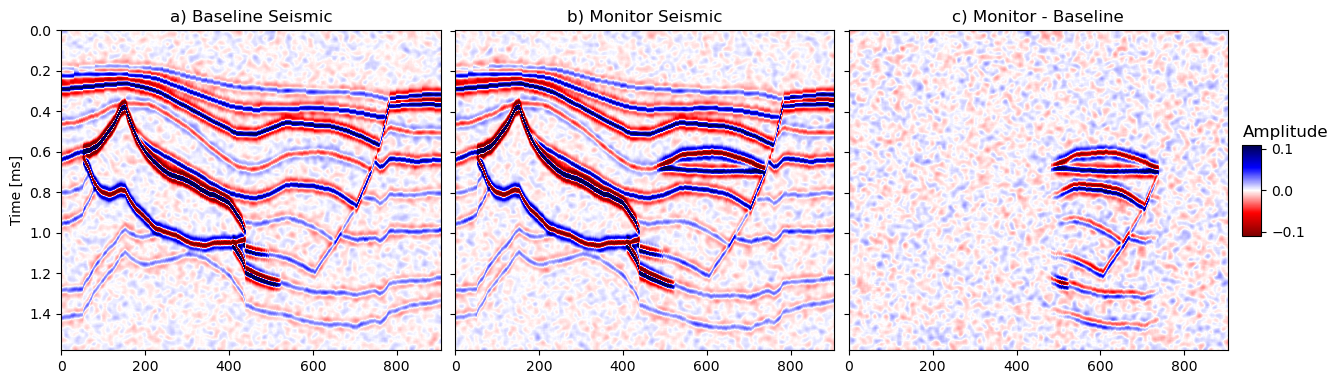

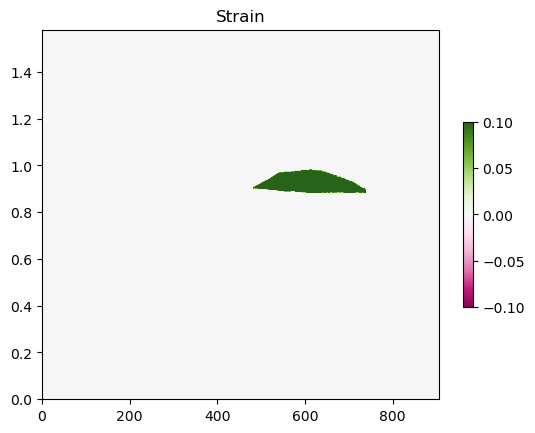

In [2]:
# We load the Hess 4D dataset which contains:
# - Baseline seismic data (d1)
# - Monitor seismic data (d2)
# - Wavelet (wav)
# - Ground truth strain (utrue)

dtype = 'float64'
hess = np.load('../data/Hess/Hess4d_time.npz')
wav = hess['wav'].astype(np.float32)
d1 = hess['dn1'].astype(np.float32)
d2 = hess['dn2'].astype(np.float32)
utrue = hess['straint'].astype(np.float32)
dims = utrue.shape
dt = 0.004
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
tautrue = C * utrue
t = np.arange(dims[0], dtype=dtype)*dt

plotter_4D(d1, d2, dt=dt, ztitle='Time [ms]', type='seismic')
plt.show()
plt.imshow(utrue, cmap='PiYG', vmin=-0.1, vmax=0.1, extent=(0, dims[1], 0, dims[0]*dt))
plt.title('Strain')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()

## Time-shift inversion

$$
\Delta \tau_i = \argmin_{\Delta \tau_i} ||d_1(t) - (d_2(t+ \tau_{i-1}) - J_{d_2}\Delta \tau)||^2 + \epsilon^2 ||\nabla^2 (\tau_{i-1} + \Delta \tau)||^2_2
$$

iter: 0, SNR: 0.456248
iter: 5, SNR: 2.950353
iter: 10, SNR: 4.358253
iter: 15, SNR: 5.303769
iter: 20, SNR: 5.947400
iter: 25, SNR: 6.393612
Total time 72.402564


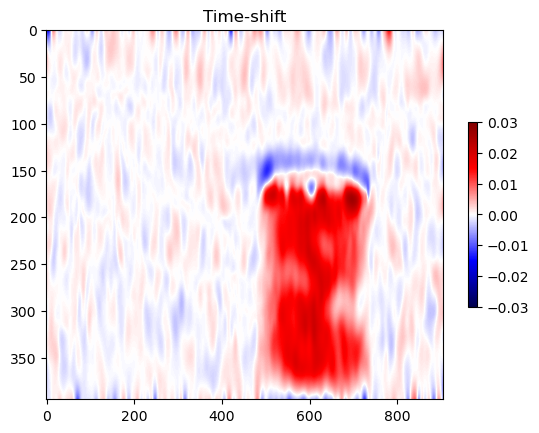

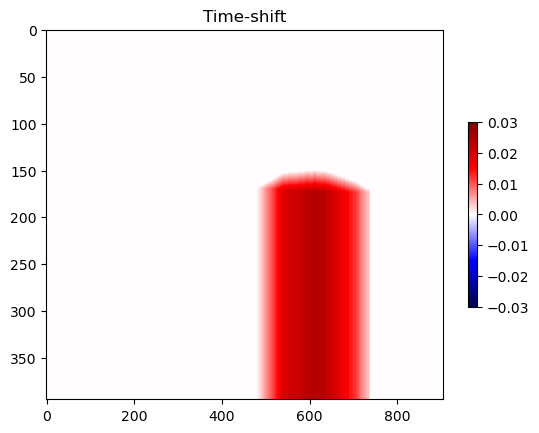

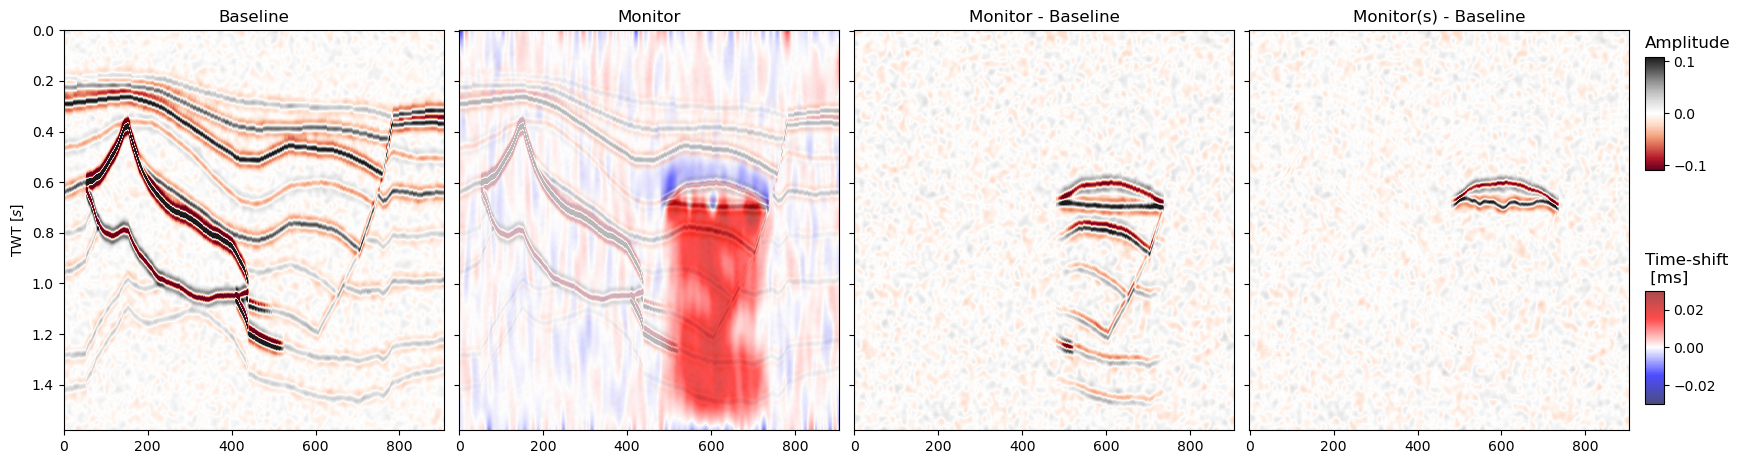

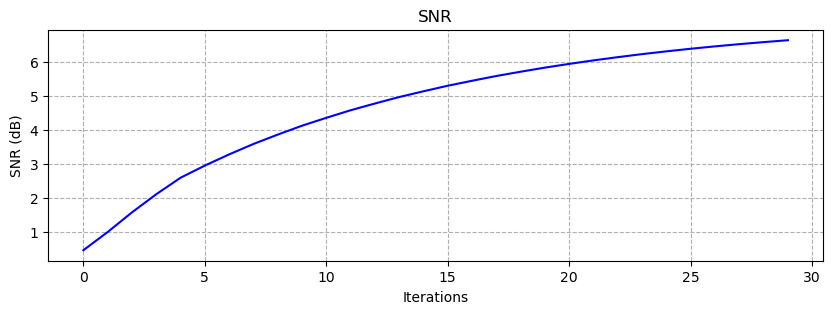

In [3]:
eps = 9e1
outeriter = 30
inneriter = 100

# Linear Operators
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)
D2op = Laplacian(dims, weights=[10, 1])

# Variables
taui = np.zeros(np.prod(dims)) # time shift at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

snrs=[]
start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel()  
    J = Diagonal(D*d2i, dtype=dtype)
    Op = J 
    lu = D2op * taui

    taui += normal_equations_inversion(
        Op=Op, y=d, 
        Regs=[D2op], 
        x0=np.zeros(np.prod(dims)),
        dataregs=[-lu], 
        epsRs=[np.sqrt(eps)],
        **dict(maxiter=inneriter))[0]
    
    interpolators = [
    interp1d((t.copy()[:, np.newaxis] - taui.reshape(dims))[:,col], d2[:, col], kind='cubic', fill_value="extrapolate")
    for col in range(d2.shape[1])]
    for col, interpolator in enumerate(interpolators):
        d2i[:, col] = interpolator(t)
    
    snrs.append(SNR(tautrue.ravel(), taui.ravel()))
    if i % 5 == 0:
        print('iter: %d, SNR: %f' % (i, snrs[-1]))

total_time = time.perf_counter() - start_time
print('Total time %f' % total_time)

plt.imshow(taui.reshape(dims), cmap='seismic', vmin=-0.03, vmax=0.03)
plt.title('Time-shift')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plt.imshow(tautrue.reshape(dims), cmap='seismic', vmin=-0.03, vmax=0.03)
plt.title('Time-shift')
plt.axis('tight')
plt.colorbar(shrink=0.5)
plt.show()
plotter_timeshift(d1, d2, d2i, shift=taui.reshape(dims), dt=dt)
plt.show()    
fig, ax = plt.subplots(figsize=(10, 3))  # Increased height slightly for better visibility
ax.plot( np.arange(len(snrs)),snrs, color='blue', linestyle='-', linewidth=1.5)
ax.set_xlabel('Iterations')
ax.set_ylabel('SNR (dB)')
ax.set_title('SNR')
ax.grid(True, linestyle='--')
plt.show()

In [4]:
np.savez('../results/time_shiftl2', shift=taui, d2s=d, snr=snrs)

## Time strain inversion - Smooth prior - data term


$$
     \Delta u = \argmin_{\Delta u}\Vert d_1(t) - d_2(t+ dt C  u_{i-1}) - dt  J_{d_2} C \Delta u \Vert^2  + \Vert \nabla^2 (\Delta u + u_{i-1})\Vert_{2}^2
$$

iter: 0, SNR: 0.854883
iter: 1, SNR: 1.378684
iter: 2, SNR: 1.742590
iter: 3, SNR: 2.066233
iter: 4, SNR: 2.185312
iter: 5, SNR: 2.262089
iter: 6, SNR: 2.322491
iter: 7, SNR: 2.362238
iter: 8, SNR: 2.393987
iter: 9, SNR: 2.412055
Total time 47.327826


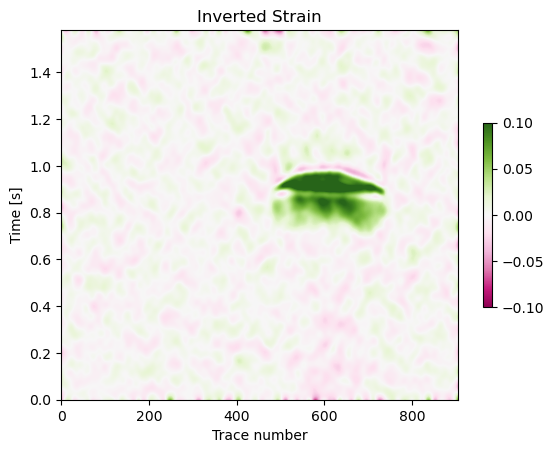

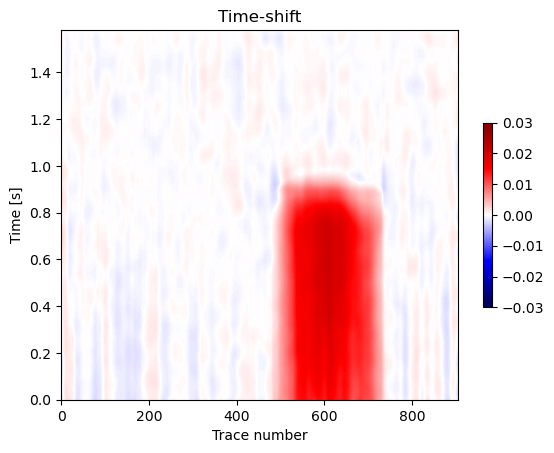

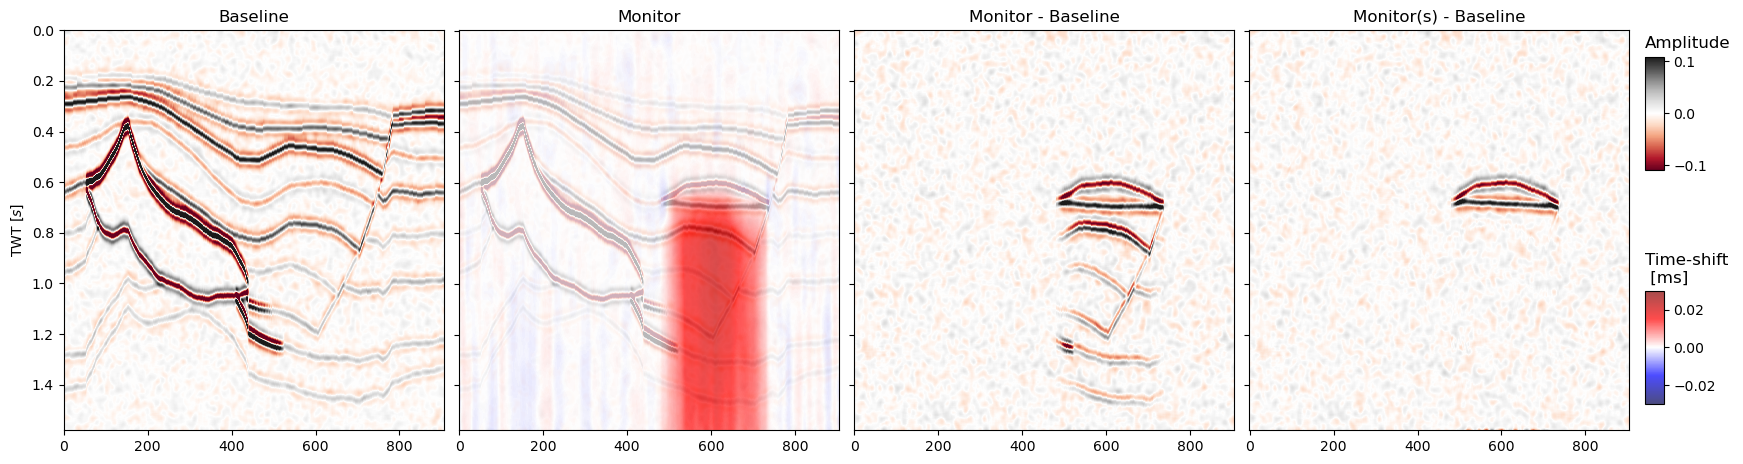

In [5]:
eps = 5e1
outeriter = 10
inneriter = 100

# Linear Operators
D = FirstDerivative(dims=dims, axis=0, sampling=dt, dtype=dtype)
G = PoststackLinearModelling(wav/2, nt0=dims[0], spatdims=dims[1:])
C = CausalIntegration(dims=dims, axis=0, sampling=dt, dtype=dtype)
D2op = Laplacian(dims, weights=[1, 1])

# Variables
ui = np.zeros(np.prod(dims)) # time shift at iteration i
d2i = d2.copy() # Shifted monitor data at iteration i

snrs=[]
start_time = time.perf_counter()
for i in range(outeriter):
    d = d1.ravel() - d2i.ravel() - (G*ui)
    J = Diagonal(D*d2i, dtype=dtype)
    Op = G + J * C
    lu = D2op * ui

    ui += normal_equations_inversion(
        Op=Op, y=d, 
        Regs=[D2op], 
        x0=np.zeros(np.prod(dims)),
        dataregs=[-lu], 
        epsRs=[np.sqrt(eps)],
        **dict(maxiter=inneriter))[0] 
    
    # Update shifted monitor data
    d2i = apply_time_shift(t, ui, d2, C, dims)
    
    snrs.append(SNR(utrue.ravel(), ui.ravel()))
    if i % 1 == 0:
        print('iter: %d, SNR: %f' % (i, snrs[-1]))

total_time = time.perf_counter() - start_time
print('Total time %f' % total_time)
# Plot results
plot_results(ui, d1, d2, d2i, C, dims, dt)

In [6]:
np.savez('../results/strainl2', strain=ui, d2s=d2i, snr=snrs)